# Video Odometry

Kevin Walchko, 7 Dec 2016

-------------

In robotics and computer vision, visual odometry is the process of determining the position and orientation of a robot by analyzing the associated camera images. It has been used in a wide variety of robotic applications, such as on the Mars Exploration Rovers.

## Overview

In navigation, odometry is the use of data from the movement of actuators to estimate change in position over time through devices such as rotary encoders to measure wheel rotations. While useful for many wheeled or tracked vehicles, traditional odometry techniques cannot be applied to mobile robots with non-standard locomotion methods, such as legged robots. In addition, odometry universally suffers from precision problems, since wheels tend to slip and slide on the floor creating a non-uniform distance traveled as compared to the wheel rotations. The error is compounded when the vehicle operates on non-smooth surfaces. Odometry readings become increasingly unreliable over time as these errors accumulate and compound over time.

Visual odometry is the process of determining equivalent odometry information using sequential camera images to estimate the distance traveled. Visual odometry allows for enhanced navigational accuracy in robots or vehicles using any type of locomotion on any surface.

## Algorithm

Most existing approaches to visual odometry are based on the following stages:

1. Acquire input images: using either single cameras.
2. Image correction: apply image processing techniques for lens distortion removal, etc.
3. Feature detection: define interest operators, and match features across frames and construct optical flow field.Construct optical flow field (Lucas–Kanade method).
3. Check flow field vectors for potential tracking errors and remove outliers.
4. Estimation of the camera motion from the optical flow.find the geometric and 3D properties of the features that minimize a cost function based on the re-projection error between two adjacent images. This can be done by mathematical minimization or random sampling.
5. Periodic repopulation of trackpoints to maintain coverage across the image.

## Ergomotion

*Egomotion* is defined as the 3D motion of a camera within an environment. In the field of computer vision, egomotion refers to estimating a camera's motion relative to a rigid scene. An example of egomotion estimation would be estimating a car's moving position relative to lines on the road or street signs being observed from the car itself. The estimation of egomotion is important in autonomous robot navigation applications.

In [1]:
%matplotlib inline

In [93]:
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
from opencvutils.video import Camera
import opencvutils as cvu
# from opencvutils.jupyter import imshow
import numpy as np
import cv2
import time

In [94]:
class VOError(Exception):
    """Exception for video odometry"""
    pass

class VideoOdom(object):
    """
    Determine translation using optical flow.
    """
    old_im = None
    p0 = None
    numberPts = 50
    
    def __init__(self, pp, focal):
        """
        Initialize the class.
        
        params:
            pp: image center tuple, (width, height)
            focal: camera focal length in mm
        """
        # pp = (240,220)
        # focal = 200.0
        self.pp = pp  # image center
        self.focal = focal  # focal length in mm

        self.R_f = np.eye(3, 3, dtype=np.float)
        self.t_f = np.array([0.0, 0, 0], dtype=np.float)  # total translation
        self.R = self.R_f.copy()
        self.t = np.array([0, 0, 0], dtype=np.float)  # delta translation

    @staticmethod
    def featureDetection(im):
        """
        Identifies potential features to track using ShiTomasi corner detection.
        
        params:
            im: current image
            
        returns:
            keypoints from cv2.goodFeaturesToTrack()
        """
        # params for ShiTomasi corner detection
        feature_params = dict(
            maxCorners=500,
            qualityLevel=0.3,
            minDistance=7,
            blockSize=7
        )
        
        keypoints = cv2.goodFeaturesToTrack(
            im,
            mask=None,
            **feature_params
        )

        return keypoints

    def cullBadPts(self, p0, p1, st, err):
        """
        Searches through points and removes bad points.
        p1, st, err = cv2.calcOpticalFlowPyrLK()
        
        params:
            p0: old points
            p1: new points
            st: array of errors
            err: ???
            
        returns:
            good_old_pts, good_new_pts
        """
        new = []
        old = []

        # Select good points
        for i in range(0, p1.shape[0]):
            if st[i][0] == 1 and p1[i][0][0] >= 0 and p1[i][0][1] >= 0:
                new.append(p1[i][0])
                old.append(p0[i][0])

        good_new = np.array([[k] for k in new], dtype=np.float32)
        good_old = np.array([[k] for k in old], dtype=np.float32)

        return good_old, good_new

    def featureTrack(self, new_gray, old_gray, p0):
        """
        Calculates optical flow using Luis Kincade techniques.
        
        params:
            new_gray: current image
            old_gray: old image
            p0: old points
            
        returns:
            old_pts, new_pts
        """
        # Parameters for lucas kanade optical flow
        lk_params = dict(
            winSize=(10, 10),
            maxLevel=3,
            criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
        )

        p1, st, err = cv2.calcOpticalFlowPyrLK(
            old_gray,
            new_gray,
            p0,
            None,
            **lk_params
        )

        p0, p1 = self.cullBadPts(p0, p1, st, err)

        return p0, p1
    
    def find(self, im):
        """
        Use a current and previous image to calculate translation using optical flow
        techniques.
        
        params:
            im: current image in grayscale
            
        returns:
            translation = np.array([x, y, z]), but z should be 0.0
            bool, total_distance, delta_distance
        """
        # make sure there is an Image, else return failure
        if im is None:
            return False, None, None
        
        # init system with current image
        # should result in zero change
        if self.old_im is None:
            self.old_im = im.copy()
            self.p0 = self.featureDetection(im)
        
        # get values from last run
        p0 = self.p0
        R = self.R
        t = self.t
        R_f = self.R_f
        t_f = self.t_f
        old_im = self.old_im
        
        try:
            # Not enough old points, p0 ... find new ones
            if p0.shape[0] < self.numberPts:
                print('------- reset p0 --------')
                p0 = self.featureDetection(old_im)
                
                if p0 is None or p0.shape[0] == 0:
                    print('bad image')
                    return False, None, None

            # p0 - old pts
            # p1 - new pts
            p0, p1 = self.featureTrack(im, old_im, p0)

            # not enough new points p1 ... bad image?
            if p1.shape[0] < self.numberPts:
                print('------- reset p1 --------')
                print('p1 size:', p1.shape)
                self.old_im = im
                self.p0 = p1
                return False, None, None

            # since these are rectified images, fundatmental (F) = essential (E)
            # E, mask = cv2.findEssentialMat(p0,p1,focal,pp,cv2.FM_RANSAC)
            # retval, R, t, mask = cv2.recoverPose(E,p0,p1,R_f,t_f,focal,pp,mask)

            E, mask = cv2.findEssentialMat(p0, p1, self.focal, self.pp, cv2.FM_RANSAC, 0.999, 1.0)
            retval, R, t, mask = cv2.recoverPose(E, p0, p1, R, t, self.focal, self.pp, mask)

            scale = 1.0
            
            # R_f is total rotation
            # R is delta rotation
            # t_f is total distance [mm]
            # t delta distance [mm]

            R_f = R.dot(R_f)
            t_f = t_f + scale * R_f.dot(t)

            # save all
            self.p0 = p1
            self.R_f = R_f
            self.t_f = t_f
            self.old_im = im.copy()
            self.t = t
            self.R = R
            
            return True, t_f, scale*R_f.dot(t)
        except:
            print('ERROR vo: something happened')
            raise

In [56]:
# dir(Camera)
# help(Camera.read)
# dir(cvu)

## Live Video

In [42]:
vo = VideoOdom((320, 240), 200)
# vo.init((320, 240), 200)
vo.numberPts = 10

cam = Camera('cv')
cam.init(win=(640, 480), cameraNumber=0)
cam.gray = True
# cam.load('camera_params.npz')
# cameraMat = cam.data['camera_matrix']

save_pts = []
for iter in range(5):
    try:
        print('Camera opended? ', cam.isOpen())
        ret, im = cam.read()

        if not ret:
            continue

        if False:
            fname = 'image_{}.png'.format(iter)
            cv2.imwrite(fname, im)
            print('saved:', fname)

        ret, t = vo.find(im)

        # print('t', t, type(t))

        if ret:
            save_pts.append(t)
        
        time.sleep(1)
        
    except:
        print('crap')
        continue
        
cam.camera.camera.release()  # fix this!

[+] Camera type 1
exiting CameraCV ... bye!
win (640, 480)
setting win size to: (640, 480)
Camera opended?  True
saved: image_0.png
t [ 0.57735027 -0.57735027  0.57735027] <type 'numpy.ndarray'>
Camera opended?  True
saved: image_1.png
t [ 1.52648375 -0.49915114  0.27234121] <type 'numpy.ndarray'>
Camera opended?  True
saved: image_2.png
t [ 2.47109117 -0.31182587  0.00284898] <type 'numpy.ndarray'>
Camera opended?  True
saved: image_3.png
t [ 3.46447361 -0.42391761 -0.02218635] <type 'numpy.ndarray'>
Camera opended?  True
saved: image_4.png
t [ 4.32413073  0.0530588  -0.20517036] <type 'numpy.ndarray'>


## Stored Images

Find translation from a series of images.

In [96]:
imgs = []
for iter in range(5):
    fname = 'image_{}.png'.format(iter)
    im = cv2.imread(fname)
    imgs.append(im)

In [98]:
vo = VideoOdom((320, 240), 200)
vo.numberPts = 10

save_pts = []
for im in imgs:
    try:
        ret, tf, t = vo.find(im)

        if ret:
            save_pts.append(t)
            
    except Exception as e:
        print('crap', e)
        continue

crap /tmp/opencv3-20161211-55427-1q3z61z/modules/imgproc/src/corner.cpp:287: error: (-215) src.type() == CV_8UC1 || src.type() == CV_32FC1 in function cornerEigenValsVecs

ERROR vo: something happened
crap 'NoneType' object has no attribute 'shape'
ERROR vo: something happened
crap 'NoneType' object has no attribute 'shape'
ERROR vo: something happened
crap 'NoneType' object has no attribute 'shape'
ERROR vo: something happened
crap 'NoneType' object has no attribute 'shape'


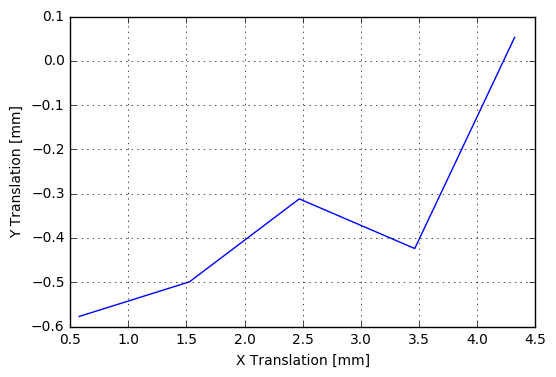

In [86]:
xx = []
yy = []
for x,y,z in save_pts:
    xx.append(x)
    yy.append(y)
plt.plot(xx, yy)
plt.grid(True)
plt.ylabel('Y Translation [mm]');
plt.xlabel('X Translation [mm]');

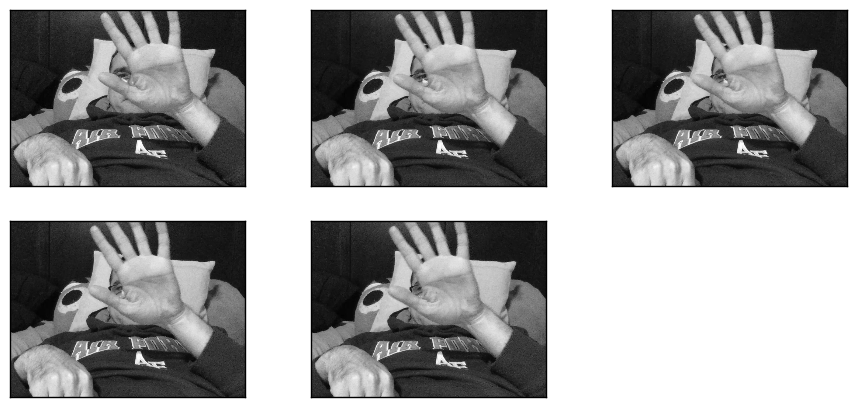

In [91]:
plt.figure(figsize=(11, 5))
for iter, im in enumerate(imgs):
    plt.subplot(2, 3, iter+1)
    plt.imshow(im)
    plt.xticks(())
    plt.yticks(())

# References

---

* [wikipedia: optical flow](https://en.wikipedia.org/wiki/Optical_flow)
* [visual odometry](https://en.wikipedia.org/wiki/Visual_odometry)
* [dead reckoning](https://en.wikipedia.org/wiki/Dead_reckoning)


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.